# Report on Location Selection for a Dessert Shop


## 1. Introduction

After having a successful career as marketing and sales executive in various organizations, a happily married housewife with 2 kids has finally decided to fulfill her dream of opening a dessert shop to share her well-liked desserts to the world.  
Karen was born in Hong Kong.  She moved to Shanghai with her husband in 2004.  Her favor desserts are cheesecake and apple pie.  Karen tried many of them in Shanghai but could not find one that she liked.  She started making them herself with different recipes available online and eventually came up with some that were well received by her families and friends.  A lot of them encouraged her to open her own shop.
With her kids going to the US for studies, Karen is now planning to move back to Hong Kong.  She decides to open a dessert shop to let other try her recipes. Karen knows Hong Kong very well and understands the competition will be very tough. However, she has confident on her recipes.  She would like some help on finding a location for her shop to maximize her chance of success.



## 2. Data for Analysis

To assist Karen on her problem, we will be using information from Foursquare to do some analysis for her.  Karen will provide a list of about 20 neighborhoods that she is interested in.  We will evaluate those neighborhoods based on ability to attract large crowd of people such as shopping malls, office buildings, theaters, popular restaurants, etc. and then select a few potential neighborhoods for her. We will then look at the number of dessert shops in each of them and select one with the minimal number of dessert shops to minimize the competition.

### Download all dependencies needed.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style
# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

## Get data file on interested neighborhoods and their geographical coordinates

In [2]:
hongkong_data = pd.read_csv('Hong_Kong_Geo_Data.csv')
hongkong_data.head()

,District,Neighborhood,Latitude,Longitude
0,Causeway Bay,Sogo,22.280298,114.184730
1,Wan Chai,Central Plaza,22.279909,114.173729
2,Central,International Finance Center,22.285879,114.158134
3,West Kowloon,International Commerce Centre,22.302820,114.161308
4,Kwai Chung,Kwai Chung,22.370157,114.123489


## Draw map with markers for all interested neighborhood

In [3]:
address = 'Hong Kong, Hong Kong'

geolocator = Nominatim(user_agent="hk_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hong Kong are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hong Kong are 22.2793278, 114.1628131.


In [4]:
# create map of Toronto using latitude and longitude values
map_hongkong = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, district, neighborhood in zip(hongkong_data['Latitude'], hongkong_data['Longitude'], hongkong_data['District'], hongkong_data['Neighborhood']):
    label = '{} - {}'.format(district, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hongkong)  
    
map_hongkong

## Define Foursquare Credentials

In [5]:
CLIENT_ID = 'EPKBPOSYGGX0RHG1ZQHN2Q2LIMTW34JXWYL1ECR3KSLECIKH' # your Foursquare ID
CLIENT_SECRET = 'XJL5W3U3UZZTM3LEEW3SGAVZTFB0X5YOKASBZYSUCWEBQ0WU' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
radius = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EPKBPOSYGGX0RHG1ZQHN2Q2LIMTW34JXWYL1ECR3KSLECIKH
CLIENT_SECRET:XJL5W3U3UZZTM3LEEW3SGAVZTFB0X5YOKASBZYSUCWEBQ0WU


## Now get all location data for all interested neighborhoods

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
#            v['venue']['location']['lat'], 
#            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
#                  'Venue Latitude', 
#                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [7]:
hongkong_venues = getNearbyVenues(names=hongkong_data['Neighborhood'],
                                   latitudes=hongkong_data['Latitude'],
                                   longitudes=hongkong_data['Longitude']
                                  )


Sogo
Central Plaza
International Finance Center
International Commerce Centre
Kwai Chung
Cheung Kong Centre
Land Mark
Cordis Hong Kong
Delta Hotel
Tsing Yi
Quarry Bay
Yau Ma Tei
Kwun Tong
Kowloon Bay
Festival Walk
Time Square
United Centre


In [8]:

print(hongkong_venues.shape)
print('There are {} uniques categories.'.format(len(hongkong_venues['Venue Category'].unique())))
hongkong_venues.head()


(1069, 5)
There are 177 uniques categories.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category
0,Sogo,22.280298,114.18473,Eslite Bookstore (誠品書店),Bookstore
1,Sogo,22.280298,114.18473,SOGO Freshmart (崇光超市),Supermarket
2,Sogo,22.280298,114.18473,Phở Lê (錦麗),Vietnamese Restaurant
3,Sogo,22.280298,114.18473,Din Tai Fung (鼎泰豐),Dumpling Restaurant
4,Sogo,22.280298,114.18473,Urban Bakery,Bakery


## 3. Analyze Each Neighborhood

In [9]:
# one hot encoding
hongkong_onehot = pd.get_dummies(hongkong_venues[['Venue Category']], prefix="", prefix_sep="")
hongkong_onehot.drop('Neighborhood',axis=1,inplace=True)

# add neighborhood column back to dataframe
hongkong_onehot['Neighborhood'] = hongkong_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [hongkong_onehot.columns[-1]] + list(hongkong_onehot.columns[:-1])
hongkong_onehot = hongkong_onehot[fixed_columns]

hongkong_onehot.head()

,Neighborhood,Airport Service,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Bistro,Bookstore,Botanical Garden,Boutique,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Café,Camera Store,Cantonese Restaurant,Cha Chaan Teng,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Coworking Space,Cupcake Shop,Cycle Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Dog Run,Donburi Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Fish Market,Food,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,General Travel,Gift Shop,Gourmet Shop,Gym,Gym / Fitness Center,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Historic Site,History Museum,Hong Kong Restaurant,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lebanese Restaurant,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Mountain,Multiplex,Music Store,Nightclub,Non-Profit,Noodle House,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pharmacy,Photography Studio,Pier,Pizza Place,Plaza,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Restaurant,Roof Deck,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Social Club,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Squash Court,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Tailor Shop,Tea Room,Tennis Court,Thai Restaurant,Theme Park Ride / Attraction,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Yoga Studio,Zhejiang Restaurant,Zoo
0,Sogo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Sogo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Sogo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,Sogo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [10]:
# let's examine the new dataframe size
hongkong_onehot.shape

(1069, 177)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [11]:
hongkong_grouped = hongkong_onehot.groupby('Neighborhood').mean().reset_index()
hongkong_grouped

,Neighborhood,Airport Service,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Bistro,Bookstore,Botanical Garden,Boutique,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Café,Camera Store,Cantonese Restaurant,Cha Chaan Teng,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Coworking Space,Cupcake Shop,Cycle Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Dog Run,Donburi Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Fish Market,Food,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,General Travel,Gift Shop,Gourmet Shop,Gym,Gym / Fitness Center,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Historic Site,History Museum,Hong Kong Restaurant,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lebanese Restaurant,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Mountain,Multiplex,Music Store,Nightclub,Non-Profit,Noodle House,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pharmacy,Photography Studio,Pier,Pizza Place,Plaza,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Restaurant,Roof Deck,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Social Club,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Squash Court,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Tailor Shop,Tea Room,Tennis Court,Thai Restaurant,Theme Park Ride / Attraction,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Yoga Studio,Zhejiang Restaurant,Zoo
0,Central Plaza,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000,0.000000,0.000000,0.025000,0.00,0.075000,0.050000,0.000000,0.025000,0.000000,0.000000,0.000000,0.000000,0.075000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000,0.00,0.000000,0.00,0.000000,0.025,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.075000,0.00,0.075000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.075000,0.000000,0.000000,0.025,0.050000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.025,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.025000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.025000,0.000000,0.000000,0.00,0.000000,0.025,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.050000,0.000000,0.000000,0.00,0.025000,0.00,0.000000,0.000000,0.025000,0.00,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000,0

First, let's write a function to sort the venues in descending order.

In [12]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [15]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = hongkong_grouped['Neighborhood']

for ind in np.arange(hongkong_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hongkong_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Plaza,Japanese Restaurant,Hong Kong Restaurant,Hotel,Coffee Shop,Cantonese Restaurant,Lounge,Steakhouse,Italian Restaurant,Cha Chaan Teng,Burger Joint
1,Cheung Kong Centre,French Restaurant,Steakhouse,Hotel,Coffee Shop,Lounge,Chinese Restaurant,Japanese Restaurant,Café,Botanical Garden,Park
2,Cordis Hong Kong,Cha Chaan Teng,Dessert Shop,Noodle House,Sporting Goods Shop,Coffee Shop,Bakery,Cantonese Restaurant,Beer Bar,Toy / Game Store,Shopping Mall
3,Delta Hotel,Japanese Restaurant,Hotel,Shopping Mall,Hotel Bar,Department Store,Chinese Restaurant,Coffee Shop,Cosmetics Shop,Tailor Shop,Indian Restaurant
4,Festival Walk,Clothing Store,Café,Japanese Restaurant,Sushi Restaurant,Coffee Shop,Chinese Restaurant,Cantonese Restaurant,Dessert Shop,American Restaurant,Supermarket


## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [16]:
# set number of clusters
kclusters = 5

hongkong_grouped_clustering = hongkong_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hongkong_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 1, 4, 2, 3, 3, 2, 2, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [17]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

hongkong_merged = hongkong_data

# merge hongkong_grouped with hongkong_data to add latitude/longitude for each neighborhood
hongkong_merged = hongkong_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

hongkong_merged.head()

,District,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Causeway Bay,Sogo,22.280298,114.184730,4,Japanese Restaurant,Chinese Restaurant,Sushi Restaurant,Hotel,Dessert Shop,Clothing Store,Szechuan Restaurant,Hotpot Restaurant,Gift Shop,Department Store
1,Wan Chai,Central Plaza,22.279909,114.173729,3,Japanese Restaurant,Hong Kong Restaurant,Hotel,Coffee Shop,Cantonese Restaurant,Lounge,Steakhouse,Italian Restaurant,Cha Chaan Teng,Burger Joint
2,Central,International Finance Center,22.285879,114.158134,3,French Restaurant,Coffee Shop,Café,Cantonese Restaurant,Spa,Hotel,Hotel Bar,Bar,Italian Restaurant,Chinese Restaurant
3,West Kowloon,International Commerce Centre,22.302820,114.161308,3,Chinese Restaurant,Japanese Restaurant,Spa,Italian Restaurant,Hotel Bar,Coffee Shop,Café,Hotel,Pub,Lounge
4,Kwai Chung,Kwai Chung,22.370157,114.123489,2,Chinese Restaurant,Cantonese Restaurant,Noodle House,Japanese Curry Restaurant,Gas Station,Restaurant,Dessert Shop,Department Store,Pool,Shopping Mall


Finally, let's visualize the resulting clusters

In [18]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hongkong_merged['Latitude'], hongkong_merged['Longitude'], hongkong_merged['Neighborhood'], hongkong_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Now find the neighborhoods with the most venues that draw crowds

In [19]:
# only keep categories that are useful

largecrowdspot=['Hotel','Gym / Fitness Center','Zoo','Park','Gym',
                'Supermarket','Shopping Mall','Department Store','Sports Club',
                'Metro Station','Skating Rink','Farmers Market','Mountain','Trail',
                'Monument / Landmark','Performing Arts Venue','Historic Site','Train Station','Scenic Lookout', 'Pier']

best_neighborhood = hongkong_venues[hongkong_venues['Venue Category'].isin(largecrowdspot)].reset_index(drop=True)


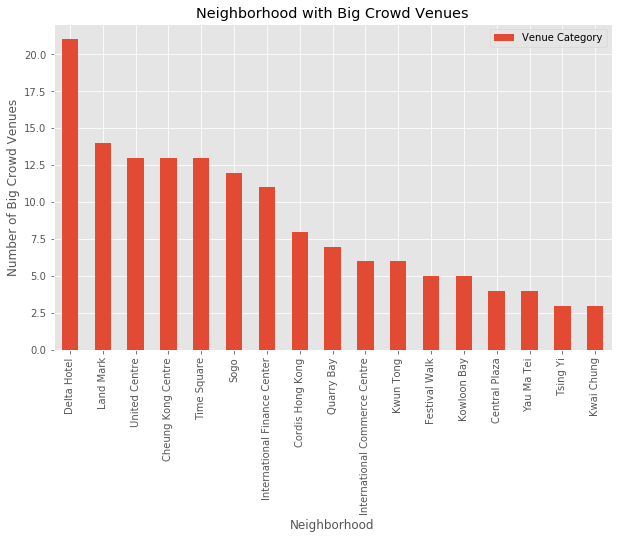

In [20]:
best_neighborhood_sorted=best_neighborhood.groupby('Neighborhood')['Venue Category'].count().to_frame().reset_index().sort_values(by='Venue Category',ascending=False)
best_neighborhood_sorted.set_index('Neighborhood', inplace=True)

best_neighborhood_sorted.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of Big Crowd Venues') # add y-label to the plot
plt.title('Neighborhood with Big Crowd Venues') # add title to the plot

plt.show()

In [21]:
# find the most competitive neighborhoods for dessert shop

most_competitive = hongkong_venues[hongkong_venues['Venue Category'] == 'Dessert Shop']

most_competitive_sorted=most_competitive.groupby('Neighborhood')['Venue Category'].count().to_frame().reset_index().sort_values(by='Venue Category')
most_competitive_sorted.reset_index(drop=True)



,Neighborhood,Venue Category
0,Delta Hotel,1
1,Kwai Chung,1
2,Land Mark,1
3,United Centre,1
4,Yau Ma Tei,1
5,Festival Walk,2
6,International Finance Center,2
7,Time Square,2
8,Kowloon Bay,3
9,Sogo,3


## Recommendation

Based on the above analysis, area around Delta Hotel has the ability to draw the largest crowd with the minimum competition.  It would be the first choice.  Other areas to consider are Land Mark and United Centre. 


In [22]:
best_neighborhood_sorted.reset_index('Neighborhood', inplace=True)

In [23]:

best_neighborhood_sorted = best_neighborhood_sorted.join(hongkong_data.set_index('Neighborhood'), on='Neighborhood')
best_neighborhood_sorted

,Neighborhood,Venue Category,District,Latitude,Longitude
0,Delta Hotel,21,Tsim Sha Tsui,22.296501,114.172806
1,Land Mark,14,Central,22.280939,114.157865
2,United Centre,13,admiralty,22.278776,114.165022
3,Cheung Kong Centre,13,admiralty,22.279428,114.160549
4,Time Square,13,Causeway Bay,22.278323,114.182121
5,Sogo,12,Causeway Bay,22.280298,114.184730
6,International Finance Center,11,Central,22.285879,114.158134
7,Cordis Hong Kong,8,Mong Kok,22.318237,114.168137
8,Quarry Bay,7,Quarry Bay,22.282721,114.212303
9,International Commerce Centre,6,West Kowloon,22.302820,114.161308


In [24]:
# create map of Toronto using latitude and longitude values
map_hongkong = folium.Map(location=[latitude, longitude], zoom_start=12)

cnt=0
# add markers to map
for lat, lng, neighborhood in zip(best_neighborhood_sorted['Latitude'], best_neighborhood_sorted['Longitude'], best_neighborhood_sorted['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    if cnt<3:
        colormark='green'
    else:
        colormark='white'
    cnt=cnt+1
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colormark,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hongkong)  
    
map_hongkong